In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn import svm
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

In [ ]:
file_id = '1ppBmnIgeYL8w2ZTxDsPZONjF_XY0DqLh'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)
df = df.sample(frac = 1) # Shuffle df
df.head() # Taiwanese Bankruptcy Prediction Dataset, 95 features
df.shape

(6819, 96)

In [ ]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [ ]:
i = -1
for col in df.columns:
    print(i, col)
    i+=1

-1 Bankrupt?
0  ROA(C) before interest and depreciation before interest
1  ROA(A) before interest and % after tax
2  ROA(B) before interest and depreciation after tax
3  Operating Gross Margin
4  Realized Sales Gross Margin
5  Operating Profit Rate
6  Pre-tax net Interest Rate
7  After-tax net Interest Rate
8  Non-industry income and expenditure/revenue
9  Continuous interest rate (after tax)
10  Operating Expense Rate
11  Research and development expense rate
12  Cash flow rate
13  Interest-bearing debt interest rate
14  Tax rate (A)
15  Net Value Per Share (B)
16  Net Value Per Share (A)
17  Net Value Per Share (C)
18  Persistent EPS in the Last Four Seasons
19  Cash Flow Per Share
20  Revenue Per Share (Yuan ¥)
21  Operating Profit Per Share (Yuan ¥)
22  Per Share Net profit before tax (Yuan ¥)
23  Realized Sales Gross Profit Growth Rate
24  Operating Profit Growth Rate
25  After-tax Net Profit Growth Rate
26  Regular Net Profit Growth Rate
27  Continuous Net Profit Growth Rate
28  

## **Train/Test Dataset**

In [ ]:
feature_df = df.drop('Bankrupt?', axis=1)
# Basis for feature selection: https://www.investopedia.com/articles/active-trading/081315/financial-ratios-spot-companies-headed-bankruptcy.asp
# feature_df = df.drop('Bankrupt?', axis=1).iloc[:, 0:11]
X = np.asarray(feature_df)
feature_df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
3224,0.211329,0.196195,0.225387,0.641750,0.641750,0.994427,0.791313,0.803597,0.302408,0.775409,...,0.611472,0.000169,0.623915,0.641746,0.830842,0.275253,0.026791,0.565158,1,0.179657
728,0.525033,0.567979,0.577012,0.610228,0.609594,0.999096,0.797533,0.809429,0.303510,0.781693,...,0.815144,0.010922,0.623313,0.610226,0.842110,0.283600,0.026852,0.565432,1,0.021086
5839,0.534003,0.585314,0.572247,0.609377,0.609377,0.999077,0.797647,0.809494,0.303748,0.781768,...,0.828978,0.001848,0.623965,0.609379,0.841981,0.276534,0.026797,0.565187,1,0.062481
3600,0.398089,0.428314,0.443118,0.597313,0.597976,0.998616,0.794804,0.806860,0.299747,0.779497,...,0.729400,0.002428,0.623395,0.597311,0.835899,0.277036,0.026777,0.565088,1,0.051349
6551,0.474431,0.537342,0.527651,0.599122,0.599122,0.998966,0.797391,0.809317,0.303533,0.781573,...,0.799815,0.001756,0.624196,0.599118,0.840308,0.278052,0.026794,0.565170,1,0.038948


In [ ]:
y = np.asarray(df['Bankrupt?']) # Target variable
df['Bankrupt?'].head()

3224    0
728     0
5839    0
3600    0
6551    0
Name: Bankrupt?, dtype: int64

# **Feature Engineering and Selection**

In [ ]:
# Adapted from https://gist.github.com/omairaasim/8e7c50d8e4f2da8f7d9078ce263fbd04
# Remove Correlated features

# Converting feature matrix into DataFrame
X_df = pd.DataFrame(X)

# Viewing the data frame
print(X_df.head())

# Creating correlation matrix
cor_matrix = X_df.corr().abs()
print(); print(cor_matrix)

# Selecting upper triangle of correlation matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
print(); print(upper_tri)

# Finding index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)

# Droping Marked Features
X_df1 = X_df.drop(X_df.columns[to_drop], axis=1)
print(); print(X_df1.head())

         0         1         2         3         4         5         6   \
0  0.211329  0.196195  0.225387  0.641750  0.641750  0.994427  0.791313   
1  0.525033  0.567979  0.577012  0.610228  0.609594  0.999096  0.797533   
2  0.534003  0.585314  0.572247  0.609377  0.609377  0.999077  0.797647   
3  0.398089  0.428314  0.443118  0.597313  0.597976  0.998616  0.794804   
4  0.474431  0.537342  0.527651  0.599122  0.599122  0.998966  0.797391   

         7         8         9   ...        85        86        87        88  \
0  0.803597  0.302408  0.775409  ...  0.611472  0.000169  0.623915  0.641746   
1  0.809429  0.303510  0.781693  ...  0.815144  0.010922  0.623313  0.610226   
2  0.809494  0.303748  0.781768  ...  0.828978  0.001848  0.623965  0.609379   
3  0.806860  0.299747  0.779497  ...  0.729400  0.002428  0.623395  0.597311   
4  0.809317  0.303533  0.781573  ...  0.799815  0.001756  0.624196  0.599118   

         89        90        91        92   93        94  
0  0.8308

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
k_best_selector = SelectKBest(chi2, k=7)

# Fit and transform the data
X = np.asarray(X_df1)
X = k_best_selector.fit_transform(X, y)

# Selected features
selected_features = k_best_selector.get_support(indices=True)
selected_features

array([21, 25, 37, 39, 47, 64, 72])

# **Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50) # 7:3 train test split
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4773, 7) (4773,)
Test set: (2046, 7) (2046,)


In [ ]:
y_train

array([1, 0, 0, ..., 0, 0, 0])

# **Implementing Support Vector Classifier**

In [ ]:
C=1.0
clf = svm.SVC(kernel="poly", degree=3, gamma="scale", C=C, class_weight='balanced', verbose=1)
#clf = svm.LinearSVC(C=C, verbose=1, max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', kernel='poly', verbose=1)

In [ ]:
y_pred = clf.predict(X_test)
print(y_pred[0:100])
print(y_test[0:100])
print(np.where(y_pred == 1))
np.where(y_test == 1)

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1]
(array([   1,   11,   31,   69,   88,  115,  136,  140,  158,  174,  190,
        198,  200,  202,  226,  229,  243,  250,  279,  283,  286,  315,
        337,  366,  368,  378,  396,  398,  411,  429,  448,  465,  476,
        500,  536,  541,  548,  549,  552,  560,  612,  616,  624,  630,
        664,  684,  690,  709,  752,  775,  810,  867,  873,  897,  908,
        912,  926,  964,  970,  985,  990,  997, 1053, 1054, 1070, 1073,
       1075, 1092, 1112, 1120, 1127, 1138, 1146, 1158, 1190, 1197, 1201,
       1202, 1221, 1222, 1225, 1268, 1269, 1309, 1316, 1317, 1322, 1350,
       

(array([   8,   91,   98,   99,  123,  128,  164,  178,  200,  208,  220,
         268,  338,  352,  367,  369,  392,  421,  487,  528,  537,  595,
         692,  714,  746,  760,  810,  823,  849,  861,  873,  878,  945,
         947,  949,  983, 1028, 1042, 1055, 1075, 1214, 1269, 1275, 1289,
        1309, 1387, 1389, 1392, 1396, 1472, 1529, 1530, 1536, 1550, 1616,
        1631, 1632, 1647, 1686, 1690, 1692, 1704, 1736, 1769, 1770, 1771,
        1785, 1894, 1924, 1929, 1971, 2021, 2024]),)

# **Implementing Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y2_pred = rf.predict(X_test)
print(y2_pred[0:100])
print(y_test[0:100])
print(np.where(y_pred == 1))
np.where(y_test == 1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1]
(array([   1,   11,   31,   69,   88,  115,  136,  140,  158,  174,  190,
        198,  200,  202,  226,  229,  243,  250,  279,  283,  286,  315,
        337,  366,  368,  378,  396,  398,  411,  429,  448,  465,  476,
        500,  536,  541,  548,  549,  552,  560,  612,  616,  624,  630,
        664,  684,  690,  709,  752,  775,  810,  867,  873,  897,  908,
        912,  926,  964,  970,  985,  990,  997, 1053, 1054, 1070, 1073,
       1075, 1092, 1112, 1120, 1127, 1138, 1146, 1158, 1190, 1197, 1201,
       1202, 1221, 1222, 1225, 1268, 1269, 1309, 1316, 1317, 1322, 1350,
       

(array([   8,   91,   98,   99,  123,  128,  164,  178,  200,  208,  220,
         268,  338,  352,  367,  369,  392,  421,  487,  528,  537,  595,
         692,  714,  746,  760,  810,  823,  849,  861,  873,  878,  945,
         947,  949,  983, 1028, 1042, 1055, 1075, 1214, 1269, 1275, 1289,
        1309, 1387, 1389, 1392, 1396, 1472, 1529, 1530, 1536, 1550, 1616,
        1631, 1632, 1647, 1686, 1690, 1692, 1704, 1736, 1769, 1770, 1771,
        1785, 1894, 1924, 1929, 1971, 2021, 2024]),)

# **Model Evaluation**

In [ ]:
print("SVC Raw Accuracy:", accuracy_score(y_test, y_pred))
print("RF Raw Accuracy:", accuracy_score(y_test, y2_pred))

SVC Raw Accuracy: 0.9115347018572825
RF Raw Accuracy: 0.967741935483871


## Generate Confusion Matrices

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1973
           1       0.07      0.12      0.09        73

    accuracy                           0.91      2046
   macro avg       0.52      0.53      0.52      2046
weighted avg       0.93      0.91      0.92      2046

Confusion matrix, without normalization
[[1856  117]
 [  64    9]]


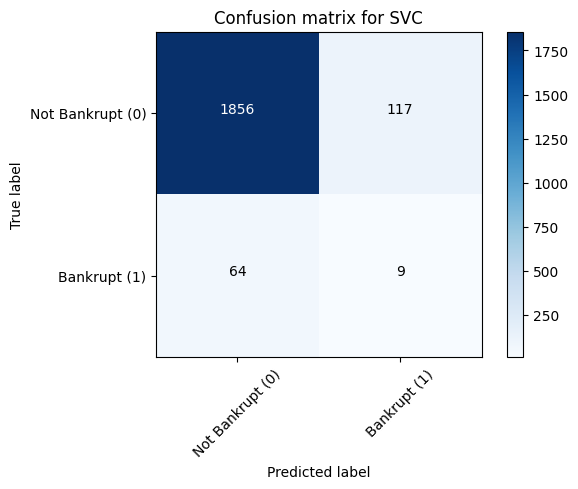

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Bankrupt (0)', 'Bankrupt (1)'],normalize= False,  title='Confusion matrix for SVC')

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1973
           1       0.89      0.11      0.20        73

    accuracy                           0.97      2046
   macro avg       0.93      0.55      0.59      2046
weighted avg       0.97      0.97      0.96      2046

Confusion matrix, without normalization
[[1972    1]
 [  65    8]]


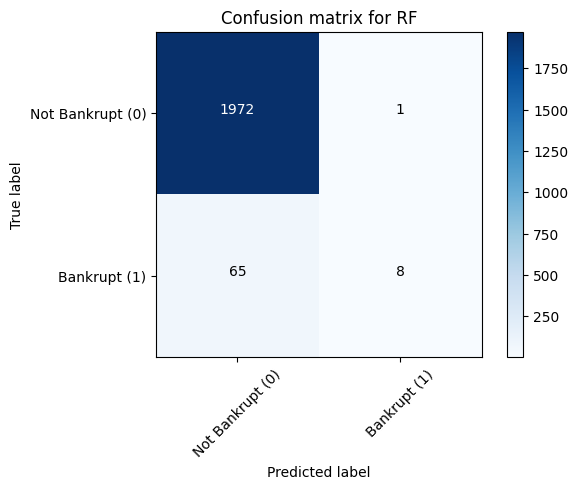

In [ ]:
# Compute confusion matrix for RF
cnf_matrix = confusion_matrix(y_test, y2_pred, labels=[0, 1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y2_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Bankrupt (0)', 'Bankrupt (1)'],normalize= False,  title='Confusion matrix for RF')

## Compute Cross-fold validation Score

In [ ]:
from sklearn.model_selection import cross_val_score
svc_score = cross_val_score(clf, X_test, y_test, cv=5)
svc_score
print()
print("%0.2f accuracy with a standard deviation of %0.2f" % (svc_score.mean(), svc_score.std()))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
0.90 accuracy with a standard deviation of 0.01


In [ ]:
rf_score = cross_val_score(rf, X_test, y_test, cv=5)
rf_score
print()
print("%0.2f accuracy with a standard deviation of %0.2f" % (rf_score.mean(), rf_score.std()))


0.97 accuracy with a standard deviation of 0.00
